In [6]:
import nasdaqdatalink as ndl
import pandas as pd
from ta import add_all_ta_features
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np


In [ ]:
#configurations
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
data_base = pd.read_csv('../data/data_base.csv', parse_dates=['date'])

# Aproximamiento probabilisitco en determinar clases



         date  portfolio_return  n_stocks  cumulative_return
0  2004-03-31          0.175815      26.0           1.175815
1  2005-03-31          0.232471      63.0           1.449158
2  2006-03-31          0.090875      65.0           1.580851
3  2007-03-31         -0.016449      59.0           1.554847
4  2008-03-31         -0.264225      18.5           1.144018
5  2009-03-31          0.441743      10.0           1.649380
6  2010-03-31          0.333353      11.0           2.199205
7  2011-03-31         -0.002525      13.0           2.193651
8  2012-03-31          0.162615       9.5           2.550371
9  2013-03-31          0.254102      54.0           3.198425
10 2014-03-31          0.165449      55.0           3.727600
11 2015-03-31         -0.004755      56.0           3.709874
12 2016-03-31          0.170256      26.0           4.341502
13 2017-03-31          0.183736      44.0           5.139191
14 2018-03-31          0.117194      49.0           5.741473
15 2019-03-31         -0

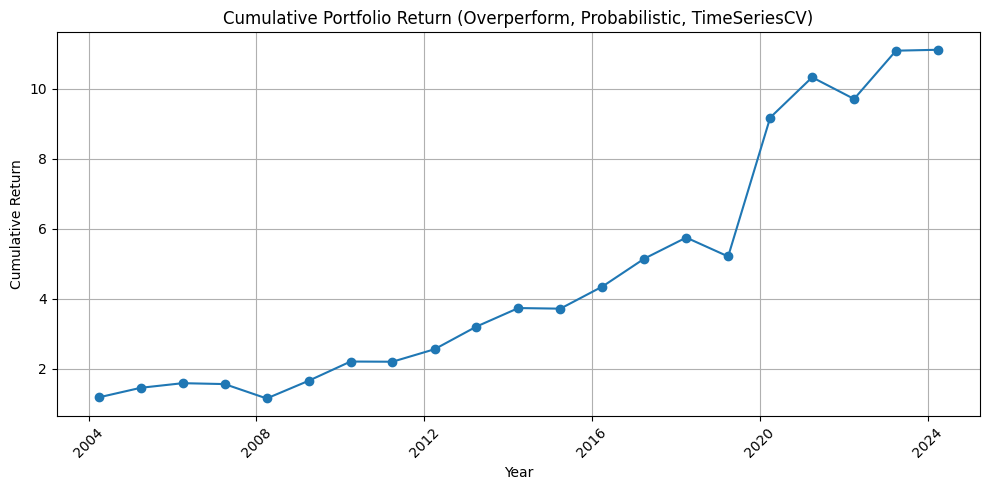

In [3]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 0. Fijar semillas aleatorias para reproducibilidad
np.random.seed(42)

# 1. Ordena por fecha para respetar la temporalidad
data_base = data_base.sort_values('date')

# 2. Define las features y prepara datos
features = [
    col for col in data_base.columns
    if col not in ['ticker', 'date', 'cap_category', 'sharpe_1y', 'target_12m_final']
    and not col.startswith('target')
]

X = data_base[features].replace([np.inf, -np.inf], np.nan)
y = data_base['target_12m_final'].replace([np.inf, -np.inf], np.nan)
mask = X.notnull().all(axis=1) & y.notnull()
X = X.loc[mask]
y = y.loc[mask]
data_filtered = data_base.loc[mask].copy()

# 3. Calcular distribución de retornos para calibración probabilística
return_bins = [-np.inf, 0.0, 0.05, 0.08, np.inf]  # Umbrales originales
return_labels = ["Negative", "Underperform", "Perform", "Overperform"]
# Corregido: Usar todas las etiquetas (4 etiquetas para 4 intervalos)
y_binned = pd.cut(y, bins=return_bins, labels=return_labels, include_lowest=True)
y_binned_counts = y_binned.value_counts(normalize=True)  # Probabilidades empíricas

# Ajustar umbrales con una función logística aproximada
def logistic_prob(return_value):
    thresholds = [0.0, 0.05, 0.08]
    probs = np.zeros(len(return_labels))
    for i, thresh in enumerate(thresholds + [np.inf]):
        if i == 0:
            probs[i] = 1 / (1 + np.exp(return_value - thresholds[i]))  # Prob Negative
        elif i == len(thresholds):
            probs[i] = 1 / (1 + np.exp(-(return_value - thresholds[i-1])))  # Prob Overperform
        else:
            probs[i] = (1 / (1 + np.exp(return_value - thresholds[i]))) - (1 / (1 + np.exp(return_value - thresholds[i-1])))  # Prob intermedia
    return probs / probs.sum()  # Normalizar para que sumen 1

# 4. Setup TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
result_list = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = xgb.XGBRegressor(
        n_estimators=300,
        learning_rate=0.07,
        max_depth=4,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42,
        early_stopping_rounds=10
    )
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    y_pred = model.predict(X_test)

    # 5. Clasificación probabilística
    prob_classes = np.array([logistic_prob(pred) for pred in y_pred])
    predicted_classes = [return_labels[np.argmax(probs)] for probs in prob_classes]
    predicted_probs = pd.DataFrame(prob_classes, columns=return_labels)

    # 6. DataFrame solo test
    df_test = data_filtered.iloc[test_idx][['date', 'ticker', 'target_12m_final', 'sharpe_1y']].copy()
    df_test['predicted_return'] = y_pred
    df_test['predicted_class'] = predicted_classes
    for label in return_labels:
        df_test[f'prob_{label}'] = predicted_probs[label]
    df_test['fold'] = fold + 1

    # 7. Retorno del portfolio de Overperform (basado en probabilidad)
    for year, group in df_test.groupby('date'):
        overperf = group[group['prob_Overperform'] > 0.5]
        if len(overperf) > 0:
            portfolio_return = overperf['target_12m_final'].mean()
            n_stocks = len(overperf)
        else:
            portfolio_return = 0.0
            n_stocks = 0
        result_list.append({
            'date': year,
            'fold': fold + 1,
            'portfolio_return': portfolio_return,
            'n_stocks': n_stocks
        })

# 8. DataFrame de resultados
results = pd.DataFrame(result_list)
results = results.sort_values(['date', 'fold'])

# 9. Métrica ANUAL: promedio sobre los folds
annual_results = results.groupby('date').agg({
    'portfolio_return': 'mean',
    'n_stocks': 'mean'
}).reset_index()

# 10. Retorno acumulado
annual_results['cumulative_return'] = (1 + annual_results['portfolio_return']).cumprod()

print(annual_results)

# 11. Gráfico de retorno acumulado
plt.figure(figsize=(10,5))
plt.plot(annual_results['date'], annual_results['cumulative_return'], marker='o')
plt.title("Cumulative Portfolio Return (Overperform, Probabilistic, TimeSeriesCV)")
plt.xlabel("Year")
plt.ylabel("Cumulative Return")
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()



# Aproximamiento probabilísitco pero promediando semillas

Este código implementa un pipeline de aprendizaje automático para predecir los retornos financieros a 12 meses (`target_12m_final`) utilizando el modelo XGBoost, respetando la naturaleza temporal de los datos mediante la ordenación por fecha y el uso de `TimeSeriesSplit` con 5 divisiones para evitar fugas de información. Las características se seleccionan excluyendo columnas como `ticker`, `date`, y variables objetivo, manejando valores faltantes mediante la sustitución de infinitos por `NaN` y filtrando filas incompletas. A diferencia de un enfoque determinista con umbrales fijos, se emplea una clasificación probabilística: los retornos predichos se transforman en probabilidades para las categorías "Negative", "Underperform", "Perform" y "Overperform" utilizando una función logística calibrada con la distribución histórica de los retornos. Los activos con una probabilidad superior al 50% de ser "Overperform" se seleccionan para formar un portafolio, cuyo retorno promedio y número de activos se calculan por fecha y fold. Para reducir la variabilidad observada al cambiar la semilla aleatoria (e.g., retornos del 400% con semilla 42 frente al 800% con semilla 43), se promedian los resultados sobre múltiples semillas (`[42, 43, 44, 45, 46]`), mejorando la robustez del modelo. Los resultados se agrupan por año, calculando el retorno acumulado, y se visualizan mediante un gráfico con `matplotlib`. Este enfoque probabilístico, combinado con el promedio de semillas, busca estabilizar las predicciones y ofrecer una estimación más fiable del rendimiento del portafolio.


         date  portfolio_return  n_stocks  cumulative_return
0  2004-03-31          0.207797      24.4           1.207797
1  2005-03-31          0.232471      63.0           1.488575
2  2006-03-31          0.090875      65.0           1.623850
3  2007-03-31         -0.016449      59.0           1.597138
4  2008-03-31         -0.292384      20.1           1.130161
5  2009-03-31          0.427647       7.0           1.613470
6  2010-03-31          0.351473       7.4           2.180562
7  2011-03-31          0.044183       7.6           2.276907
8  2012-03-31          0.158765       9.8           2.638399
9  2013-03-31          0.254242      53.6           3.309190
10 2014-03-31          0.166054      54.8           3.858694
11 2015-03-31         -0.003468      55.0           3.845313
12 2016-03-31          0.205580      26.6           4.635834
13 2017-03-31          0.197132      43.6           5.549706
14 2018-03-31          0.142251      49.0           6.339155
15 2019-03-31         -0

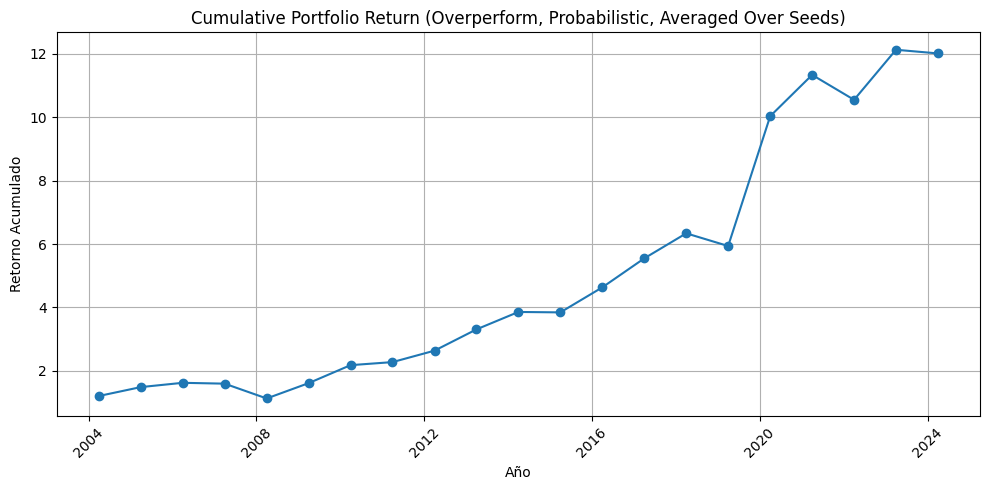

In [ ]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 0. Lista de semillas para promediar y fijar reproducibilidad
seeds = [42, 43, 44, 45, 46]
all_results = []

for seed in seeds:
    # Fijar semilla para cada iteración
    np.random.seed(seed)

    # 1. Ordena por fecha para respetar la temporalidad
    data_base = data_base.sort_values('date')

    # 2. Define las features y prepara datos
    features = [
        col for col in data_base.columns
        if col not in ['ticker', 'date', 'cap_category', 'sharpe_1y', 'target_12m_final']
        and not col.startswith('target')
    ]

    X = data_base[features].replace([np.inf, -np.inf], np.nan)
    y = data_base['target_12m_final'].replace([np.inf, -np.inf], np.nan)
    mask = X.notnull().all(axis=1) & y.notnull()
    X = X.loc[mask]
    y = y.loc[mask]
    data_filtered = data_base.loc[mask].copy()

    # 3. Calcular distribución de retornos para calibración probabilística
    return_bins = [-np.inf, 0.0, 0.05, 0.08, np.inf]  # Umbrales originales
    return_labels = ["Negative", "Underperform", "Perform", "Overperform"]
    y_binned = pd.cut(y, bins=return_bins, labels=return_labels, include_lowest=True)
    y_binned_counts = y_binned.value_counts(normalize=True)  # Probabilidades empíricas

    # Ajustar umbrales con una función logística aproximada
    def logistic_prob(return_value):
        thresholds = [0.0, 0.05, 0.08]
        probs = np.zeros(len(return_labels))
        for i, thresh in enumerate(thresholds + [np.inf]):
            if i == 0:
                probs[i] = 1 / (1 + np.exp(return_value - thresholds[i]))  # Prob Negative
            elif i == len(thresholds):
                probs[i] = 1 / (1 + np.exp(-(return_value - thresholds[i-1])))  # Prob Overperform
            else:
                probs[i] = (1 / (1 + np.exp(return_value - thresholds[i]))) - (1 / (1 + np.exp(return_value - thresholds[i-1])))  # Prob intermedia
        return probs / probs.sum()  # Normalizar para que sumen 1

    # 4. Setup TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=5)
    result_list = []

    for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = xgb.XGBRegressor(

            n_jobs=1, # No paralelizar para evitar diferentes resultados por semilla 
            n_estimators=300,
            learning_rate=0.07,
            max_depth=4,  # Reducido para estabilidad
            subsample=0.9,
            colsample_bytree=0.9,
            random_state=seed,  # Semilla específica por iteración
            early_stopping_rounds=10
        )
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
        y_pred = model.predict(X_test)

        # 5. Clasificación probabilística
        prob_classes = np.array([logistic_prob(pred) for pred in y_pred])
        predicted_classes = [return_labels[np.argmax(probs)] for probs in prob_classes]
        predicted_probs = pd.DataFrame(prob_classes, columns=return_labels)

        # 6. DataFrame solo test
        df_test = data_filtered.iloc[test_idx][['date', 'ticker', 'target_12m_final', 'sharpe_1y']].copy()
        df_test['predicted_return'] = y_pred
        df_test['predicted_class'] = predicted_classes
        for label in return_labels:
            df_test[f'prob_{label}'] = predicted_probs[label]
        df_test['fold'] = fold + 1

        # 7. Retorno del portfolio de Overperform (basado en probabilidad)
        for year, group in df_test.groupby('date'):
            overperf = group[group['prob_Overperform'] > 0.5]
            if len(overperf) > 0:
                portfolio_return = overperf['target_12m_final'].mean()
                n_stocks = len(overperf)
            else:
                portfolio_return = 0.0
                n_stocks = 0
            result_list.append({
                'date': year,
                'fold': fold + 1,
                'portfolio_return': portfolio_return,
                'n_stocks': n_stocks,
                'seed': seed  # Añadido para rastrear la semilla
            })

    # 8. DataFrame de resultados por semilla
    results = pd.DataFrame(result_list)
    results = results.sort_values(['date', 'fold'])
    all_results.append(results)

# 9. Promediar resultados sobre todas las semillas
all_results_df = pd.concat(all_results)
annual_results = all_results_df.groupby(['date']).agg({
    'portfolio_return': 'mean',
    'n_stocks': 'mean'
}).reset_index()

# 10. Retorno acumulado
annual_results['cumulative_return'] = (1 + annual_results['portfolio_return']).cumprod()

print(annual_results)

# 11. Gráfico de retorno acumulado
plt.figure(figsize=(10,5))
plt.plot(annual_results['date'], annual_results['cumulative_return'], marker='o')
plt.title("Cumulative Portfolio Return (Overperform, Probabilistic, Averaged Over Seeds)")
plt.xlabel("Año")
plt.ylabel("Retorno Acumulado")
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

In [7]:
start = 1998
end = 2025

for year in range(start, end):
    unique_tickers = data_base[data_base['date'] == f'{year}-03-31']['ticker'].nunique()
    print(f"Año {year}: {unique_tickers} tickers únicos")


Año 1998: 0 tickers únicos
Año 1999: 416 tickers únicos
Año 2000: 472 tickers únicos
Año 2001: 469 tickers únicos
Año 2002: 476 tickers únicos
Año 2003: 488 tickers únicos
Año 2004: 490 tickers únicos
Año 2005: 494 tickers únicos
Año 2006: 494 tickers únicos
Año 2007: 492 tickers únicos
Año 2008: 493 tickers únicos
Año 2009: 496 tickers únicos
Año 2010: 497 tickers únicos
Año 2011: 496 tickers únicos
Año 2012: 494 tickers únicos
Año 2013: 494 tickers únicos
Año 2014: 496 tickers únicos
Año 2015: 497 tickers únicos
Año 2016: 491 tickers únicos
Año 2017: 497 tickers únicos
Año 2018: 496 tickers únicos
Año 2019: 496 tickers únicos
Año 2020: 496 tickers únicos
Año 2021: 499 tickers únicos
Año 2022: 496 tickers únicos
Año 2023: 498 tickers únicos
Año 2024: 498 tickers únicos


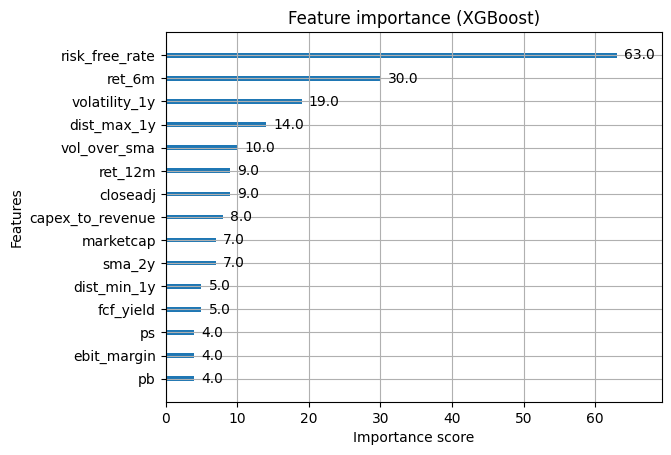

In [9]:
import matplotlib.pyplot as plt
import xgboost as xgb

xgb.plot_importance(model, max_num_features=15)
plt.title("Feature importance (XGBoost)")
plt.show()


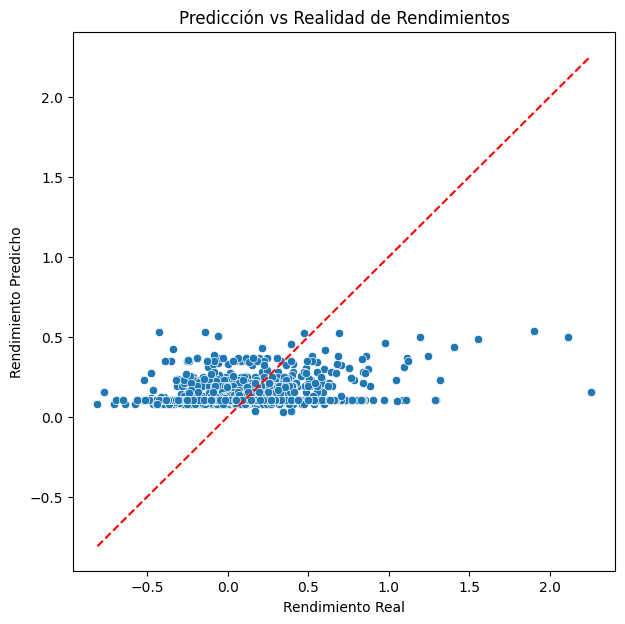

In [11]:
plt.figure(figsize=(7,7))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Rendimiento Real')
plt.ylabel('Rendimiento Predicho')
plt.title('Predicción vs Realidad de Rendimientos') 
plt.show()


In [13]:
# Apply to test set predictions and real values
y_test_class = y_test.apply(sharpe_class)
y_pred_class = pd.Series(y_pred).apply(sharpe_class)

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

cm = confusion_matrix(y_test_class, y_pred_class, labels=["Underperform", "Normal", "Overperform"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Under", "Normal", "Over"])
disp.plot()
plt.title("Confusion Matrix for Sharpe Ratio Classes")
plt.show()

print(classification_report(y_test_class, y_pred_class, digits=3))

NameError: name 'sharpe_class' is not defined

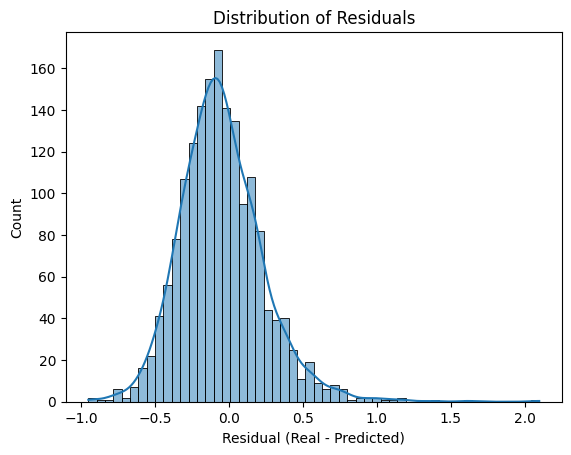

In [14]:
residuals = y_test - y_pred
sns.histplot(residuals, kde=True)
plt.title("Distribution of Residuals")
plt.xlabel("Residual (Real - Predicted)")
plt.show()


In [ ]:
results_df = data_base.loc[y_test.index, ['ticker', 'date']].copy()
results_df['sharpe_true'] = y_test
results_df['sharpe_pred'] = y_pred
results_df['sharpe_true_class'] = y_test_class.values
results_df['sharpe_pred_class'] = y_pred_class.values

over_df = results_df[results_df['sharpe_pred_class'] == 'Overperform']

over_df_sorted = over_df.sort_values(['date', 'ticker'])
display(over_df_sorted[['date', 'ticker']])


AttributeError: 'numpy.ndarray' object has no attribute 'values'